**1. LOAD THE REQUIREMENTS**

In [1]:
!pip install scikit-learn
!pip install pandas
!pip install seaborn
!ip install --pre torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/cu128
!pip install tensorflow
!pip install imblearn

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\Ander\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\Ander\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\Ander\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip
"ip" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\Ander\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\Ander\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import Counter
from torch.utils.data import DataLoader,Dataset, Subset 
from torchvision import models, transforms, datasets
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18
from sklearn.metrics import balanced_accuracy_score
import os
import shutil
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from sklearn.utils import class_weight
from torch.optim.lr_scheduler import StepLR
import random
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    ConfusionMatrixDisplay,
    classification_report
)

**2. LOAD FUNCTIONS**

In [2]:
def prepare_labels(csv_path, label_mapping=None):
    df = pd.read_csv(csv_path)
    class_columns = df.columns[1:]
    df['label_name'] = df[class_columns].idxmax(axis=1)
    
    if label_mapping is None:
        label_mapping = {name: idx for idx, name in enumerate(class_columns)}
    
    df['label_idx'] = df['label_name'].map(label_mapping)
    return df, label_mapping

train_df, label_mapping = prepare_labels('D:/TFM/ISIC2018_Task3_Training_GroundTruth.csv')
val_df, _ = prepare_labels('D:/TFM/ISIC2018_Task3_Validation_GroundTruth.csv', label_mapping)
test_df, _ = prepare_labels('D:/TFM/ISIC2018_Task3_Test_GroundTruth.csv', label_mapping)

In [3]:
class ISICDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.df = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = os.path.join(self.image_dir, row['image'] + '.jpg')
        image = Image.open(image_path).convert('RGB')
        
        label = row['label_idx']
        
        if self.transform:
            image = self.transform(image)

        return image, label

In [24]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor()
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataset = ISICDataset(train_df, 'D:/TFM/ISIC2018_Task3_Training_Input', transform=train_transform)
val_dataset   = ISICDataset(val_df, 'D:/TFM/ISIC2018_Task3_Validation_Input', transform=val_test_transform)
test_dataset  = ISICDataset(test_df, 'D:/TFM/ISIC2018_Task3_Test_Input', transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [7]:
def compute_class_weights(df, label_column='label_idx', num_classes=7):
    class_counts = df[label_column].value_counts().sort_index()

    total = class_counts.sum()
    weights = total / (num_classes * class_counts)  

    class_weights = torch.tensor(weights.values, dtype=torch.float)
    return class_weights


class_weights = compute_class_weights(train_df)


In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, path='best_model.pth'):
        self.patience = patience
        self.verbose = verbose
        self.path = path
        self.counter = 0
        self.best_loss = float('inf')
        self.best_model_wts = None

    def __call__(self, model, val_loss):
        if val_loss < self.best_loss:
            if self.verbose:
                if self.best_loss == float('inf'):
                    print(f'Validation loss initialized to {val_loss:.4f}. Saving model...')
                else:
                    print(f'Validation loss decreased ({self.best_loss:.4f} -> {val_loss:.4f}). Saving model...')
            self.best_loss = val_loss
            self.counter = 0
            self.best_model_wts = model.state_dict()
            torch.save(self.best_model_wts, self.path)
        else:
            self.counter += 1
            if self.verbose:
                print(f'Validation loss did not improve. Counter: {self.counter}/{self.patience}')
        if self.counter >= self.patience:
            print('Early stopping triggered')
            return True
        return False


In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        self.fc1 = nn.Linear(64 * 28 * 28, 512)  # ← Actualizado para 224x224
        self.dropout = nn.Dropout(0.4)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


**4. RESNET18 MODEL**

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = resnet18(pretrained=True)

num_classes = 7
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

C:\Users\Ander\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Ander\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
def train(model, train_loader, val_loader, criterion, optimizer, device,
          label_mapping, num_epochs=20, patience=5):

    best_acc = 0.0
    epochs_no_improve = 0
    class_names = list(label_mapping.keys())

    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        avg_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)

        model.eval()
        val_preds = []
        val_labels = []
        val_running_loss = 0.0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

                val_running_loss += loss.item() * images.size(0)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        avg_val_loss = val_running_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)

        val_preds = np.array(val_preds)
        val_labels = np.array(val_labels)

        val_bal_acc = balanced_accuracy_score(val_labels, val_preds)
        per_class_recall = recall_score(val_labels, val_preds, average=None)
        val_accuracies.append(val_bal_acc)

        if val_bal_acc > best_acc:
            best_acc = val_bal_acc
            torch.save(model.state_dict(), 'best_model.pth')
            print(f"Modelo guardado (mejor hasta ahora: {best_acc:.4f})")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f"No mejora ({epochs_no_improve}/{patience})")

        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print(f"  Train Loss: {avg_train_loss:.4f}")
        print(f"  Val Loss: {avg_val_loss:.4f}")
        print(f"  Val Balanced Accuracy: {val_bal_acc:.4f}")
        print("  Accuracy por clase:")
        for i, class_name in enumerate(class_names):
            print(f"    {class_name}: {per_class_recall[i]:.4f}")

        if epochs_no_improve >= patience:
            print("\nDetenido por early stopping.")
            break

    plt.figure(figsize=(8, 6))
    plt.plot(train_losses, label='train_loss', color='blue')
    plt.plot(val_losses, label='val_loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train and Validation Losses Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print("\nEvaluando el mejor modelo en el conjunto de validación...")

    model.load_state_dict(torch.load('best_model.pth'))
    model.eval()
    best_val_preds = []
    best_val_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            best_val_preds.extend(preds.cpu().numpy())
            best_val_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(best_val_labels, best_val_preds, normalize='true')
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title("Normalized Confusion Matrix (Best Model)")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

Modelo guardado (mejor hasta ahora: 0.6904)

Epoch 1/20
  Train Loss: 0.6928
  Val Loss: 0.6805
  Val Balanced Accuracy: 0.6904
  Accuracy por clase:
    MEL: 0.7619
    NV: 0.7154
    BCC: 0.8667
    AKIEC: 0.6250
    BKL: 0.8636
    DF: 0.0000
    VASC: 1.0000
Modelo guardado (mejor hasta ahora: 0.8228)

Epoch 2/20
  Train Loss: 0.5570
  Val Loss: 0.5209
  Val Balanced Accuracy: 0.8228
  Accuracy por clase:
    MEL: 0.7143
    NV: 0.8049
    BCC: 0.9333
    AKIEC: 0.6250
    BKL: 0.6818
    DF: 1.0000
    VASC: 1.0000
No mejora (1/10)

Epoch 3/20
  Train Loss: 0.4568
  Val Loss: 0.4907
  Val Balanced Accuracy: 0.7832
  Accuracy por clase:
    MEL: 0.6667
    NV: 0.8049
    BCC: 0.5333
    AKIEC: 0.7500
    BKL: 0.7273
    DF: 1.0000
    VASC: 1.0000
Modelo guardado (mejor hasta ahora: 0.8374)

Epoch 4/20
  Train Loss: 0.4410
  Val Loss: 0.5747
  Val Balanced Accuracy: 0.8374
  Accuracy por clase:
    MEL: 0.7619
    NV: 0.7886
    BCC: 0.8000
    AKIEC: 0.8750
    BKL: 0.6364
    DF:

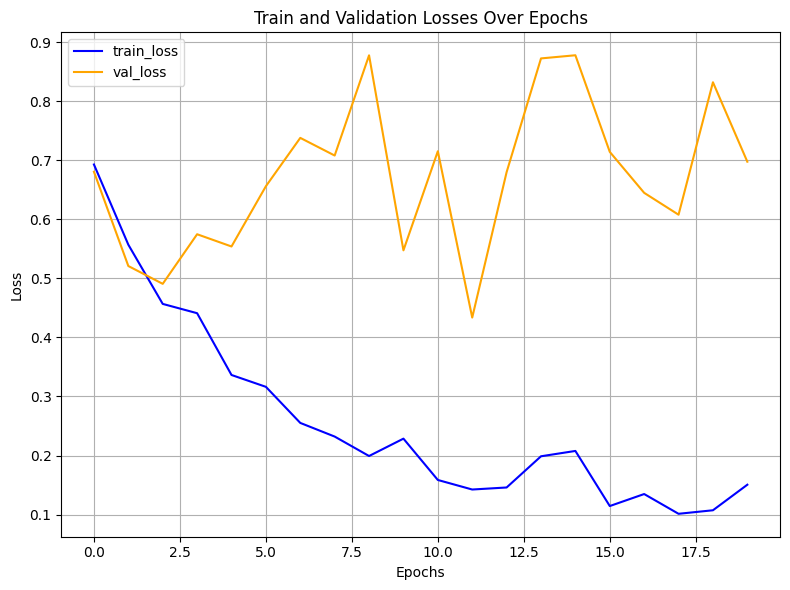


Evaluando el mejor modelo en el conjunto de validación...


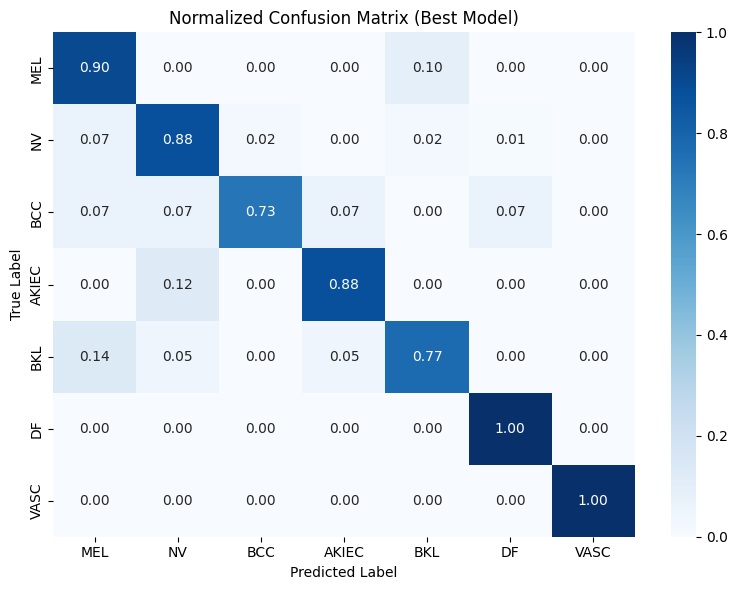

In [128]:
train(model, train_loader, val_loader, criterion, optimizer, device,label_mapping, num_epochs=20, patience=10)


✅ Test Balanced Accuracy: 0.7110
📊 Accuracy por clase en el test set:
  MEL: 0.6550
  NV: 0.8130
  BCC: 0.7527
  AKIEC: 0.7907
  BKL: 0.6498
  DF: 0.6591
  VASC: 0.6571


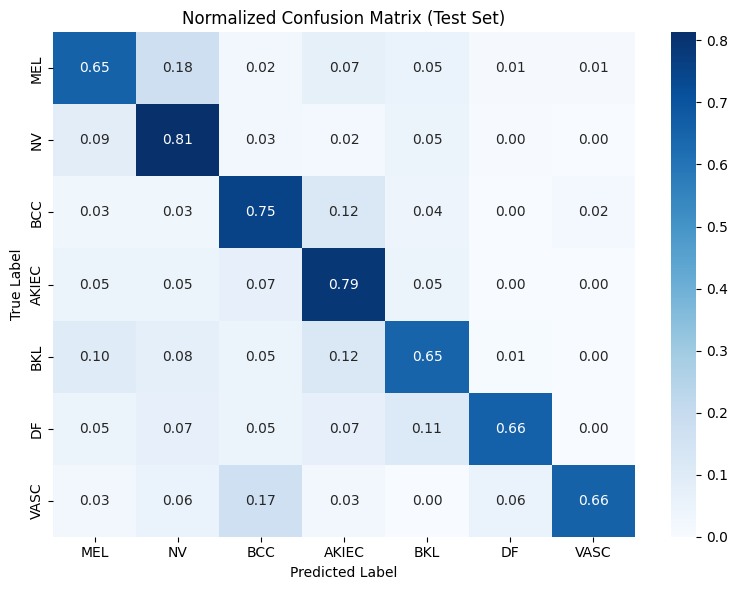

In [ ]:
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

test_preds = []
test_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_preds = np.array(test_preds)
test_labels = np.array(test_labels)

test_bal_acc = balanced_accuracy_score(test_labels, test_preds)
test_recall_per_class = recall_score(test_labels, test_preds, average=None)

print(f"\n Test Balanced Accuracy: {test_bal_acc:.4f}")
print(" Accuracy por clase en el test set:")
for i, class_name in enumerate(label_mapping.keys()):
    print(f"  {class_name}: {test_recall_per_class[i]:.4f}")

cm = confusion_matrix(test_labels, test_preds, normalize='true')
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=label_mapping.keys(),
            yticklabels=label_mapping.keys())
plt.title("Normalized Confusion Matrix (Test Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

**4. CROSS VALIDATION**

**4.1 SIMPLE CNN**

**4.1.1 WITH CLASS WEIGHTING**


======== Fold 1 ========
Class Weights (Fold 1):
Class 0 (AKIEC): weight = 4.3529
Class 1 (BCC): weight = 2.7579
Class 2 (BKL): weight = 1.3005
Class 3 (DF): weight = 12.6801
Class 4 (MEL): weight = 1.2848
Class 5 (NV): weight = 0.2136
Class 6 (VASC): weight = 10.0567
Validation loss initialized to 1.2459. Saving model...
Validation loss decreased (1.2459 -> 1.2332). Saving model...
Validation loss did not improve. Counter: 1/10
Validation loss did not improve. Counter: 2/10
Validation loss did not improve. Counter: 3/10
Validation loss did not improve. Counter: 4/10
Validation loss decreased (1.2332 -> 1.1676). Saving model...
Validation loss decreased (1.1676 -> 1.0930). Saving model...
Validation loss did not improve. Counter: 1/10
Validation loss decreased (1.0930 -> 1.0568). Saving model...
Validation loss decreased (1.0568 -> 1.0165). Saving model...
Validation loss did not improve. Counter: 1/10
Validation loss did not improve. Counter: 2/10
Validation loss decreased (1.0165 ->

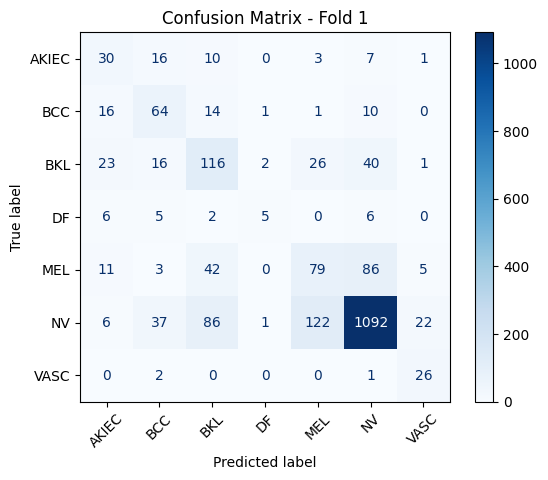


======== Fold 2 ========
Class Weights (Fold 2):
Class 0 (AKIEC): weight = 4.3529
Class 1 (BCC): weight = 2.7579
Class 2 (BKL): weight = 1.3005
Class 3 (DF): weight = 12.5438
Class 4 (MEL): weight = 1.2862
Class 5 (NV): weight = 0.2136
Class 6 (VASC): weight = 10.0567
Validation loss initialized to 1.5470. Saving model...
Validation loss decreased (1.5470 -> 1.2876). Saving model...
Validation loss did not improve. Counter: 1/10
Validation loss did not improve. Counter: 2/10
Validation loss did not improve. Counter: 3/10
Validation loss decreased (1.2876 -> 1.2836). Saving model...
Validation loss did not improve. Counter: 1/10
Validation loss did not improve. Counter: 2/10
Validation loss did not improve. Counter: 3/10
Validation loss decreased (1.2836 -> 1.0723). Saving model...
Validation loss did not improve. Counter: 1/10
Validation loss did not improve. Counter: 2/10
Validation loss decreased (1.0723 -> 1.0416). Saving model...
Validation loss did not improve. Counter: 1/10
Vali

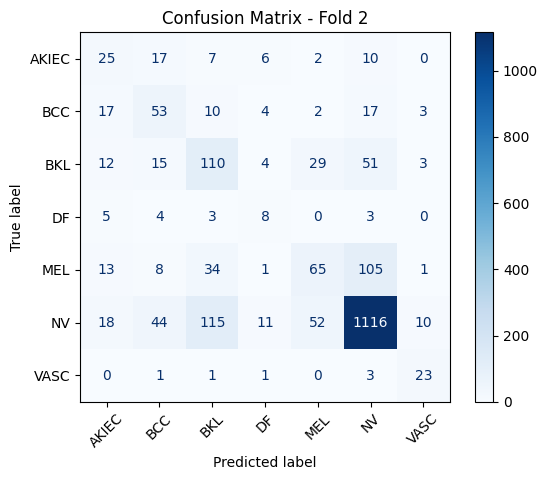


======== Fold 3 ========
Class Weights (Fold 3):
Class 0 (AKIEC): weight = 4.3529
Class 1 (BCC): weight = 2.7579
Class 2 (BKL): weight = 1.3005
Class 3 (DF): weight = 12.5438
Class 4 (MEL): weight = 1.2862
Class 5 (NV): weight = 0.2136
Class 6 (VASC): weight = 10.0567
Validation loss initialized to 1.3403. Saving model...
Validation loss decreased (1.3403 -> 1.2139). Saving model...
Validation loss did not improve. Counter: 1/10
Validation loss did not improve. Counter: 2/10
Validation loss did not improve. Counter: 3/10
Validation loss did not improve. Counter: 4/10
Validation loss did not improve. Counter: 5/10
Validation loss did not improve. Counter: 6/10
Validation loss decreased (1.2139 -> 1.0287). Saving model...
Validation loss did not improve. Counter: 1/10
Validation loss did not improve. Counter: 2/10
Validation loss did not improve. Counter: 3/10
Validation loss did not improve. Counter: 4/10
Validation loss did not improve. Counter: 5/10
Validation loss did not improve. C

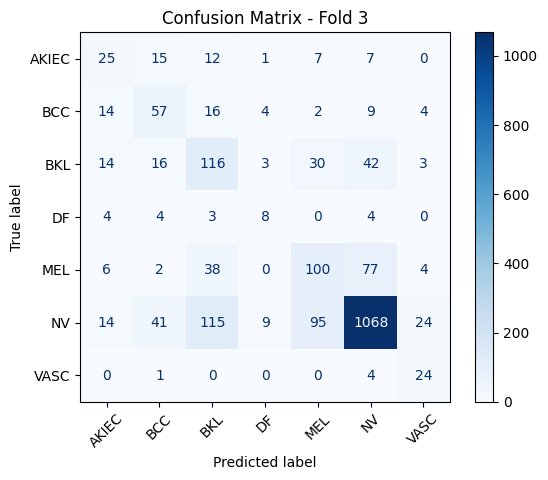


======== Fold 4 ========
Class Weights (Fold 4):
Class 0 (AKIEC): weight = 4.3534
Class 1 (BCC): weight = 2.7582
Class 2 (BKL): weight = 1.3007
Class 3 (DF): weight = 12.5453
Class 4 (MEL): weight = 1.2863
Class 5 (NV): weight = 0.2136
Class 6 (VASC): weight = 10.0579
Validation loss initialized to 1.5285. Saving model...
Validation loss decreased (1.5285 -> 1.3736). Saving model...
Validation loss decreased (1.3736 -> 1.3376). Saving model...
Validation loss decreased (1.3376 -> 1.2657). Saving model...
Validation loss did not improve. Counter: 1/10
Validation loss did not improve. Counter: 2/10
Validation loss did not improve. Counter: 3/10
Validation loss did not improve. Counter: 4/10
Validation loss did not improve. Counter: 5/10
Validation loss decreased (1.2657 -> 1.1826). Saving model...
Validation loss did not improve. Counter: 1/10
Validation loss did not improve. Counter: 2/10
Validation loss did not improve. Counter: 3/10
Validation loss did not improve. Counter: 4/10
Vali

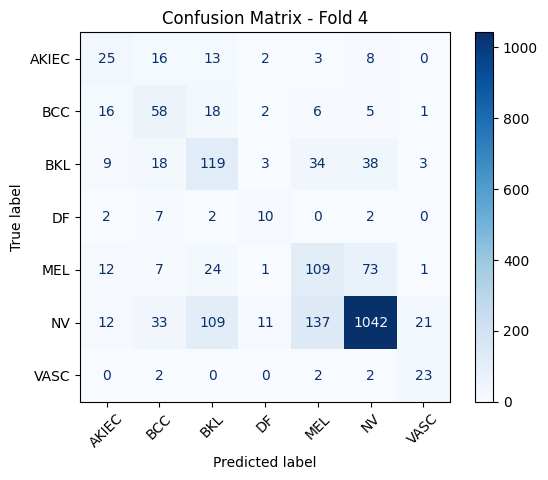


======== Fold 5 ========
Class Weights (Fold 5):
Class 0 (AKIEC): weight = 4.3534
Class 1 (BCC): weight = 2.7517
Class 2 (BKL): weight = 1.3021
Class 3 (DF): weight = 12.5453
Class 4 (MEL): weight = 1.2863
Class 5 (NV): weight = 0.2136
Class 6 (VASC): weight = 10.0579
Validation loss initialized to 1.3908. Saving model...
Validation loss did not improve. Counter: 1/10
Validation loss decreased (1.3908 -> 1.2005). Saving model...
Validation loss did not improve. Counter: 1/10
Validation loss did not improve. Counter: 2/10
Validation loss did not improve. Counter: 3/10
Validation loss did not improve. Counter: 4/10
Validation loss decreased (1.2005 -> 1.1408). Saving model...
Validation loss did not improve. Counter: 1/10
Validation loss decreased (1.1408 -> 1.0773). Saving model...
Validation loss did not improve. Counter: 1/10
Validation loss did not improve. Counter: 2/10
Validation loss did not improve. Counter: 3/10
Validation loss decreased (1.0773 -> 0.9401). Saving model...
Vali

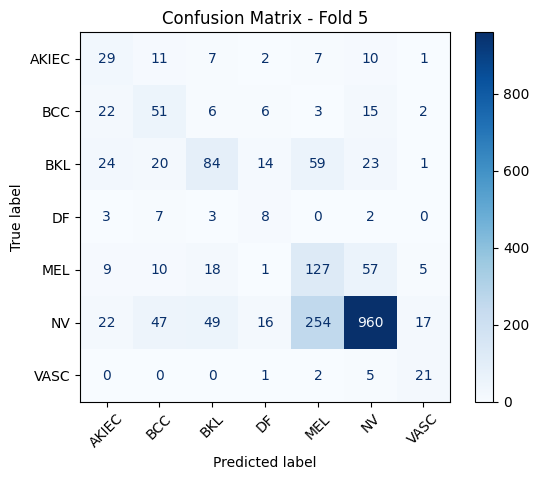


======== Final Combined Results (All Folds) ========
              precision    recall  f1-score   support

       AKIEC     0.3018    0.4000    0.3440       335
         BCC     0.3997    0.5350    0.4576       529
         BKL     0.4186    0.4862    0.4499      1121
          DF     0.2671    0.3362    0.2977       116
         MEL     0.3535    0.4233    0.3852      1134
          NV     0.8797    0.7730    0.8229      6828
        VASC     0.4680    0.8069    0.5924       145

    accuracy                         0.6736     10208
   macro avg     0.4412    0.5372    0.4785     10208
weighted avg     0.7139    0.6736    0.6894     10208



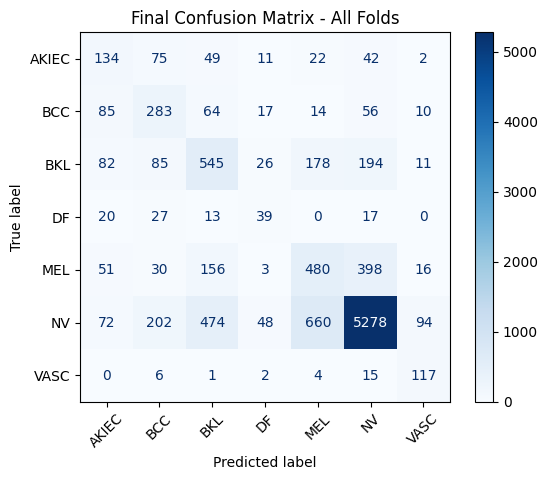

In [26]:
data_path = r"D:\TFM\data\train_val_full"
dataset = datasets.ImageFolder(root=data_path, transform=transform)
targets = np.array(dataset.targets)
class_names = dataset.classes
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
all_preds, all_labels = [], []

for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(targets)), targets)):
    print(f'\n======== Fold {fold + 1} ========')

    train_subset = Subset(dataset, train_idx)
    val_subset = Subset(dataset, val_idx)
    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

    train_targets = [targets[i] for i in train_idx]
    class_counts = Counter(train_targets)
    total = sum(class_counts.values())
    num_classes = len(class_counts)
    weights = [
        total / (num_classes * class_counts[i]) if class_counts[i] > 0 else 0.0
        for i in range(num_classes)
    ]
    weights = torch.FloatTensor(weights)
    class_weights = weights.to(device)

    print("Class Weights (Fold {}):".format(fold+1))
    for idx, w in enumerate(weights):
        print(f"Class {idx} ({class_names[idx]}): weight = {w:.4f}")


    model = SimpleCNN(num_classes=7).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    early_stopping = EarlyStopping(patience=10, verbose=True, path=f'best_model_fold{fold}.pth')

    for epoch in range(50):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            loss = criterion(model(inputs), labels)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0.0
        val_preds, val_true = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
                preds = outputs.argmax(dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_true.extend(labels.cpu().numpy())
        if early_stopping(model, val_loss / len(val_loader)):
            break

    model.load_state_dict(torch.load(f'best_model_fold{fold}.pth'))

    model.eval()
    fold_preds, fold_labels = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            preds = model(inputs).argmax(dim=1)
            fold_preds.extend(preds.cpu().numpy())
            fold_labels.extend(labels.cpu().numpy())
    all_preds.extend(fold_preds)
    all_labels.extend(fold_labels)

    print(f"Classification Report - Fold {fold+1}")
    print(classification_report(fold_labels, fold_preds, target_names=class_names, digits=4))

    cm = confusion_matrix(fold_labels, fold_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(xticks_rotation=45, cmap='Blues')
    plt.title(f"Confusion Matrix - Fold {fold+1}")
    plt.show()

print("\n======== Final Combined Results (All Folds) ========")
print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))
final_cm = confusion_matrix(all_labels, all_preds)
final_disp = ConfusionMatrixDisplay(confusion_matrix=final_cm, display_labels=class_names)
final_disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Final Confusion Matrix - All Folds")
plt.show()

Evaluando modelo fold 0 en el test set...
Evaluando modelo fold 1 en el test set...
Evaluando modelo fold 2 en el test set...
Evaluando modelo fold 3 en el test set...
Evaluando modelo fold 4 en el test set...

======== Resultados del Test Set (Ensamble de 5 Folds) ========
              precision    recall  f1-score   support

       AKIEC     0.2239    0.3488    0.2727        43
         BCC     0.3636    0.4301    0.3941        93
         BKL     0.4038    0.3963    0.4000       217
          DF     0.2778    0.1136    0.1613        44
         MEL     0.3540    0.4678    0.4030       171
          NV     0.8361    0.7635    0.7982       909
        VASC     0.3333    0.4571    0.3855        35

    accuracy                         0.6190      1512
   macro avg     0.3989    0.4253    0.4021      1512
weighted avg     0.6452    0.6190    0.6284      1512



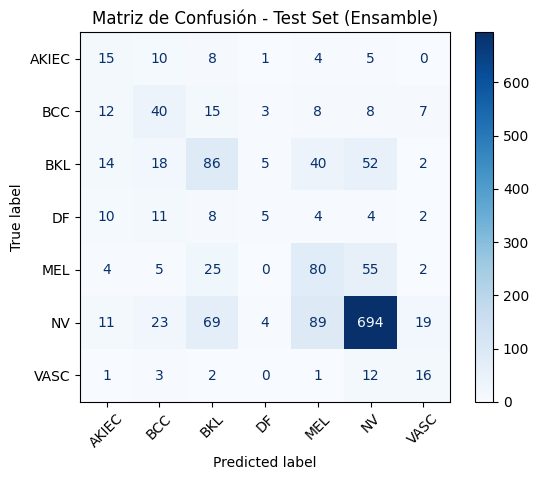

In [28]:
test_data_path = r"D:\TFM\ISIC2018\test"
test_dataset = datasets.ImageFolder(root=test_data_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

test_labels = [label for _, label in test_dataset]

all_test_preds = []

for fold in range(k_folds):
    print(f"Evaluando modelo fold {fold} en el test set...")
    model = SimpleCNN(num_classes=7).to(device)
    model.load_state_dict(torch.load(f'best_model_fold{fold}.pth'))
    model.eval()
    
    fold_preds = []
    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            fold_preds.append(preds.cpu().numpy())
    
    all_test_preds.append(np.concatenate(fold_preds))

all_test_preds = np.array(all_test_preds)

ensemble_preds = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=all_test_preds)

print("\n======== Resultados del Test Set (Ensamble de 5 Folds) ========")
print(classification_report(test_labels, ensemble_preds, target_names=class_names, digits=4))

cm_test_ensemble = confusion_matrix(test_labels, ensemble_preds)
disp_test_ensemble = ConfusionMatrixDisplay(confusion_matrix=cm_test_ensemble, display_labels=class_names)
disp_test_ensemble.plot(xticks_rotation=45, cmap='Blues')
plt.title("Matriz de Confusión - Test Set (Ensamble)")
plt.show()


**4.1.2 WITHOUT CLASS WEIGHTING**


======== Fold 1 ========
Validation loss decreased (0.8831 -> 0.8831). Saving model...
Validation loss did not improve. Counter: 1/10
Validation loss decreased (0.7792 -> 0.7792). Saving model...
Validation loss decreased (0.7086 -> 0.7086). Saving model...
Validation loss did not improve. Counter: 1/10
Validation loss decreased (0.6805 -> 0.6805). Saving model...
Validation loss did not improve. Counter: 1/10
Validation loss decreased (0.6476 -> 0.6476). Saving model...
Validation loss did not improve. Counter: 1/10
Validation loss decreased (0.6429 -> 0.6429). Saving model...
Validation loss did not improve. Counter: 1/10
Validation loss did not improve. Counter: 2/10
Validation loss did not improve. Counter: 3/10
Validation loss did not improve. Counter: 4/10
Validation loss did not improve. Counter: 5/10
Validation loss did not improve. Counter: 6/10
Validation loss did not improve. Counter: 7/10
Validation loss did not improve. Counter: 8/10
Validation loss did not improve. Count

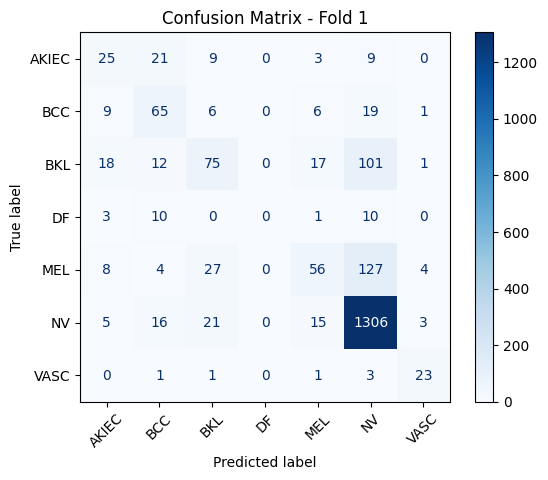

Classification Report - Fold 1
              precision    recall  f1-score   support

       AKIEC     0.3676    0.3731    0.3704        67
         BCC     0.5039    0.6132    0.5532       106
         BKL     0.5396    0.3348    0.4132       224
          DF     0.0000    0.0000    0.0000        24
         MEL     0.5657    0.2478    0.3446       226
          NV     0.8292    0.9561    0.8881      1366
        VASC     0.7188    0.7931    0.7541        29

    accuracy                         0.7591      2042
   macro avg     0.5035    0.4740    0.4748      2042
weighted avg     0.7249    0.7591    0.7292      2042

Fold 1 - Acc: 0.7591 | Prec: 0.5035 | Rec: 0.4740 | F1: 0.4748

======== Fold 2 ========
Validation loss decreased (0.8217 -> 0.8217). Saving model...
Validation loss decreased (0.8179 -> 0.8179). Saving model...
Validation loss decreased (0.7170 -> 0.7170). Saving model...
Validation loss did not improve. Counter: 1/10
Validation loss did not improve. Counter: 2/10
Val

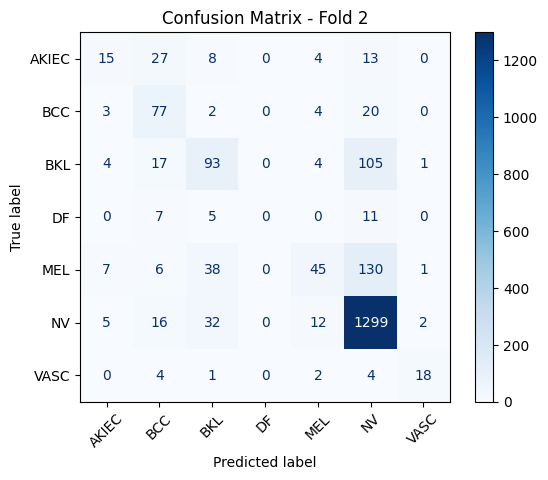

Classification Report - Fold 2
              precision    recall  f1-score   support

       AKIEC     0.4412    0.2239    0.2970        67
         BCC     0.5000    0.7264    0.5923       106
         BKL     0.5196    0.4152    0.4615       224
          DF     0.0000    0.0000    0.0000        23
         MEL     0.6338    0.1982    0.3020       227
          NV     0.8211    0.9510    0.8813      1366
        VASC     0.8182    0.6207    0.7059        29

    accuracy                         0.7576      2042
   macro avg     0.5334    0.4479    0.4629      2042
weighted avg     0.7288    0.7576    0.7243      2042

Fold 2 - Acc: 0.7576 | Prec: 0.5334 | Rec: 0.4479 | F1: 0.4629

======== Fold 3 ========
Validation loss decreased (0.9606 -> 0.9606). Saving model...
Validation loss decreased (0.7892 -> 0.7892). Saving model...
Validation loss decreased (0.7660 -> 0.7660). Saving model...
Validation loss decreased (0.7621 -> 0.7621). Saving model...
Validation loss decreased (0.6719 -

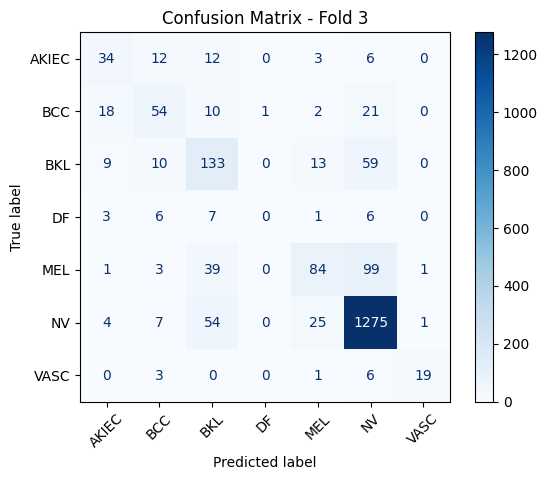

Classification Report - Fold 3
              precision    recall  f1-score   support

       AKIEC     0.4928    0.5075    0.5000        67
         BCC     0.5684    0.5094    0.5373       106
         BKL     0.5216    0.5938    0.5553       224
          DF     0.0000    0.0000    0.0000        23
         MEL     0.6512    0.3700    0.4719       227
          NV     0.8662    0.9334    0.8985      1366
        VASC     0.9048    0.6552    0.7600        29

    accuracy                         0.7831      2042
   macro avg     0.5721    0.5099    0.5319      2042
weighted avg     0.7675    0.7831    0.7695      2042

Fold 3 - Acc: 0.7831 | Prec: 0.5721 | Rec: 0.5099 | F1: 0.5319

======== Fold 4 ========
Validation loss decreased (0.8527 -> 0.8527). Saving model...
Validation loss decreased (0.7718 -> 0.7718). Saving model...
Validation loss did not improve. Counter: 1/10
Validation loss decreased (0.7606 -> 0.7606). Saving model...
Validation loss did not improve. Counter: 1/10
Val

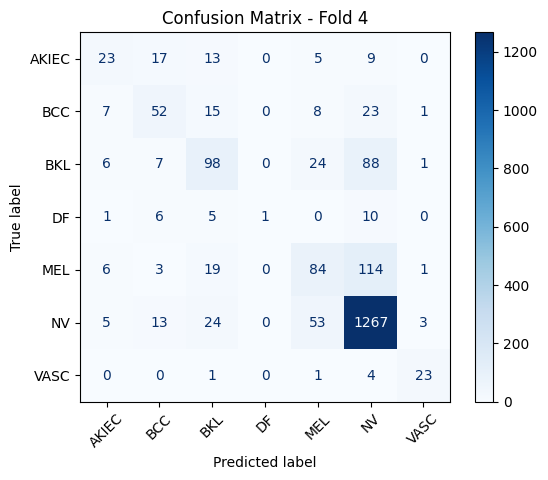

Classification Report - Fold 4
              precision    recall  f1-score   support

       AKIEC     0.4792    0.3433    0.4000        67
         BCC     0.5306    0.4906    0.5098       106
         BKL     0.5600    0.4375    0.4912       224
          DF     1.0000    0.0435    0.0833        23
         MEL     0.4800    0.3700    0.4179       227
          NV     0.8363    0.9282    0.8799      1365
        VASC     0.7931    0.7931    0.7931        29

    accuracy                         0.7585      2041
   macro avg     0.6685    0.4866    0.5107      2041
weighted avg     0.7400    0.7585    0.7407      2041

Fold 4 - Acc: 0.7585 | Prec: 0.6685 | Rec: 0.4866 | F1: 0.5107

======== Fold 5 ========
Validation loss decreased (0.7962 -> 0.7962). Saving model...
Validation loss decreased (0.7531 -> 0.7531). Saving model...
Validation loss decreased (0.7249 -> 0.7249). Saving model...
Validation loss did not improve. Counter: 1/10
Validation loss decreased (0.6814 -> 0.6814). Savi

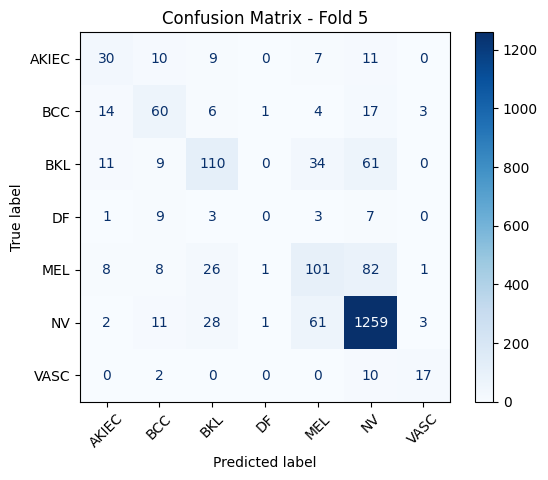

Classification Report - Fold 5
              precision    recall  f1-score   support

       AKIEC     0.4545    0.4478    0.4511        67
         BCC     0.5505    0.5714    0.5607       105
         BKL     0.6044    0.4889    0.5405       225
          DF     0.0000    0.0000    0.0000        23
         MEL     0.4810    0.4449    0.4622       227
          NV     0.8701    0.9223    0.8954      1365
        VASC     0.7083    0.5862    0.6415        29

    accuracy                         0.7727      2041
   macro avg     0.5241    0.4945    0.5074      2041
weighted avg     0.7553    0.7727    0.7626      2041

Fold 5 - Acc: 0.7727 | Prec: 0.5241 | Rec: 0.4945 | F1: 0.5074

======== Final Results ========


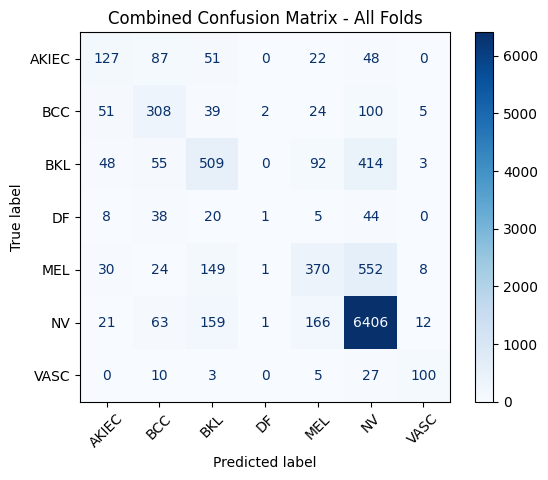

Final Classification Report:
              precision    recall  f1-score   support

       AKIEC     0.4456    0.3791    0.4097       335
         BCC     0.5265    0.5822    0.5530       529
         BKL     0.5473    0.4541    0.4963      1121
          DF     0.2000    0.0086    0.0165       116
         MEL     0.5409    0.3263    0.4070      1134
          NV     0.8439    0.9382    0.8885      6828
        VASC     0.7812    0.6897    0.7326       145

    accuracy                         0.7662     10208
   macro avg     0.5551    0.4826    0.5005     10208
weighted avg     0.7399    0.7662    0.7468     10208



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score,
    f1_score, ConfusionMatrixDisplay, classification_report
)
import numpy as np
import matplotlib.pyplot as plt


data_path = r"D:\TFM\data\train_val_full"
dataset = datasets.ImageFolder(root=data_path, transform=transform)
targets = np.array(dataset.targets)
class_names = dataset.classes

k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

all_preds = []
all_labels = []


for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(targets)), targets)):
    print(f"\n======== Fold {fold + 1} ========")

    train_subset = Subset(dataset, train_idx)
    val_subset = Subset(dataset, val_idx)

    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

    model = SimpleCNN(num_classes=7).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    early_stopping = EarlyStopping(patience=10, verbose=True, path=f'model_fold{fold}.pth')

    for epoch in range(50):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0.0
        val_preds, val_true = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds = outputs.argmax(dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_true.extend(labels.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        if early_stopping(model, avg_val_loss):
            break

    model.load_state_dict(torch.load(f'model_fold{fold}.pth'))
    model.eval()
    fold_preds, fold_labels = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            fold_preds.extend(preds.cpu().numpy())
            fold_labels.extend(labels.cpu().numpy())

    all_preds.extend(fold_preds)
    all_labels.extend(fold_labels)

    cm = confusion_matrix(fold_labels, fold_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(xticks_rotation=45, cmap='Blues')
    plt.title(f"Confusion Matrix - Fold {fold+1}")
    plt.show()

    print(f"Classification Report - Fold {fold+1}")
    print(classification_report(fold_labels, fold_preds, target_names=class_names, digits=4, zero_division=0))

    acc = accuracy_score(fold_labels, fold_preds)
    prec = precision_score(fold_labels, fold_preds, average='macro', zero_division=0)
    rec = recall_score(fold_labels, fold_preds, average='macro', zero_division=0)
    f1 = f1_score(fold_labels, fold_preds, average='macro', zero_division=0)
    print(f"Fold {fold+1} - Acc: {acc:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f} | F1: {f1:.4f}")

print("\n======== Final Results ========")
final_cm = confusion_matrix(all_labels, all_preds)
final_disp = ConfusionMatrixDisplay(confusion_matrix=final_cm, display_labels=class_names)
final_disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Combined Confusion Matrix - All Folds")
plt.show()

print("Final Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names, digits=4, zero_division=0))


Classification Report on Test Set:
              precision    recall  f1-score   support

       AKIEC     0.3000    0.2791    0.2892        43
         BCC     0.4000    0.5376    0.4587        93
         BKL     0.5665    0.5300    0.5476       217
          DF     0.0000    0.0000    0.0000        44
         MEL     0.4421    0.7368    0.5526       171
          NV     0.8304    0.5680    0.6746       250
        VASC     0.6667    0.5143    0.5806        35

    accuracy                         0.5428       853
   macro avg     0.4580    0.4523    0.4433       853
weighted avg     0.5622    0.5428    0.5362       853



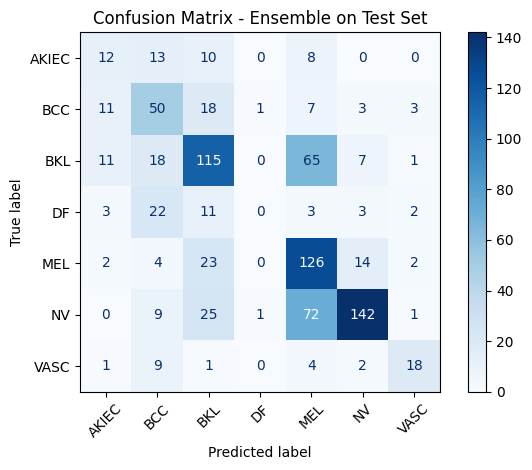

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

test_data_path = r"D:\TFM\data\test"  # Your test folder path
model_paths = [f"best_model_fold{i}.pth" for i in range(5)]
batch_size = 32
num_classes = 7
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

test_dataset = datasets.ImageFolder(root=test_data_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
class_names = test_dataset.classes

models = []
for path in model_paths:
    model = SimpleCNN(num_classes=num_classes).to(device)
    model.load_state_dict(torch.load(path, map_location=device))
    model.eval()
    models.append(model)

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        ensemble_outputs = torch.zeros((inputs.size(0), num_classes), device=device)

        for model in models:
            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1)
            ensemble_outputs += probs

        ensemble_outputs /= len(models)
        preds = torch.argmax(ensemble_outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

print("Classification Report on Test Set:")
print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix - Ensemble on Test Set")
plt.tight_layout()
plt.show()



**5. EXTRAS**

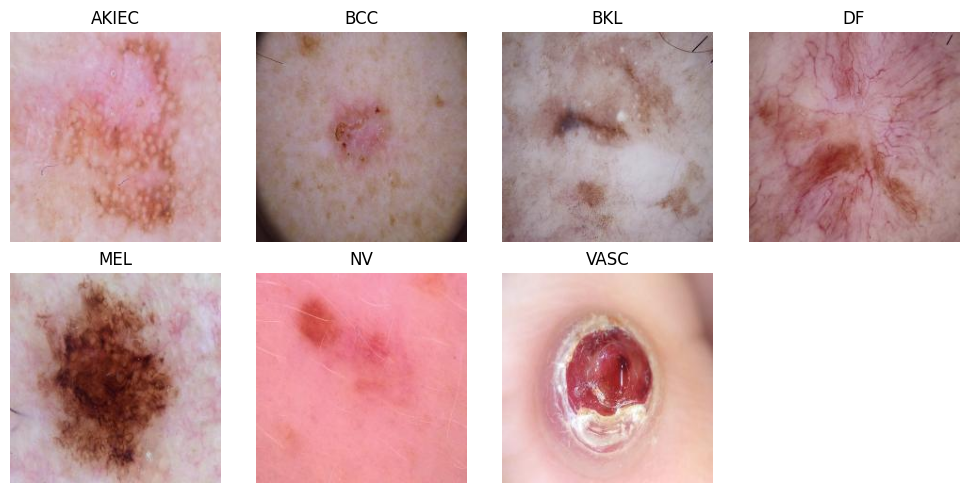

In [ ]:
test_dataset1 = datasets.ImageFolder(test_pre)  

class_names = test_dataset1.classes

fig, axes = plt.subplots(2, 4, figsize=(10, 5))  

axes = axes.flatten()

for i, class_name in enumerate(class_names):
    class_idx = test_dataset1.class_to_idx[class_name]
    class_indices = [idx for idx, label in enumerate(test_dataset1.targets) if label == class_idx]
    
  
    img_idx = class_indices[0]
    image, _ = test_dataset1[img_idx]  
    
    
    image = np.array(image)  
    
    
    axes[i].imshow(image)
    axes[i].axis('off') 
    axes[i].set_title(class_name) 
    
    
    axes[i].set_aspect('equal')


fig.delaxes(axes[-1])
plt.savefig('class_images.pdf', dpi=600) 

plt.tight_layout()
plt.show()

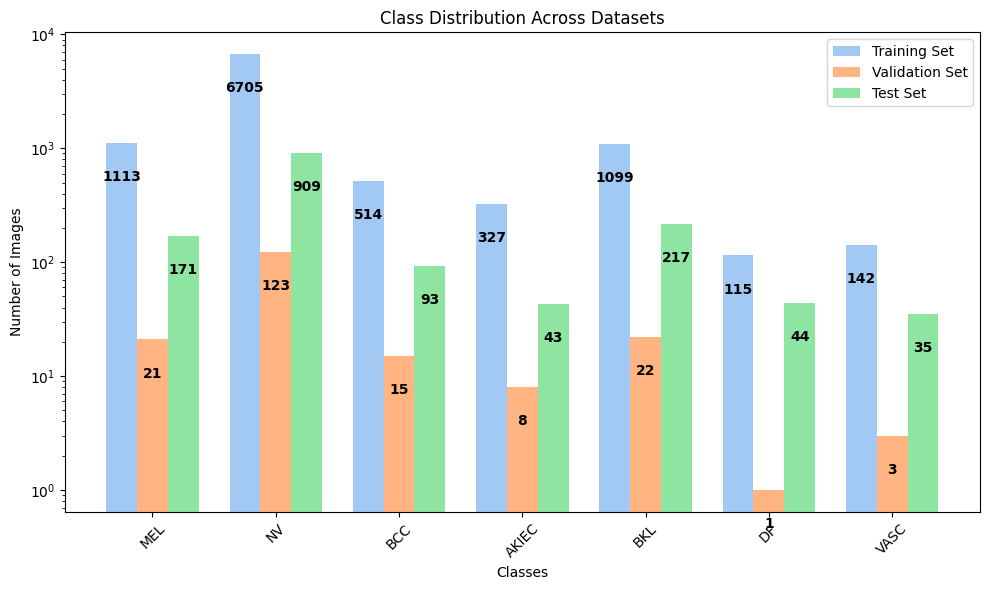

In [ ]:
train_class_counts = train_df.iloc[:, 1:].sum(axis=0)  
val_class_counts = val_df.iloc[:, 1:].sum(axis=0) 
test_class_counts = test_df.iloc[:, 1:].sum(axis=0)  


fig, ax = plt.subplots(figsize=(10, 6))  


x = range(len(classes))


bar_width = 0.25


train_bars = ax.bar([p - bar_width for p in x], train_class_counts.values, bar_width, label='Training Set', color=sns.color_palette("pastel", 7)[0])
val_bars = ax.bar(x, val_class_counts.values, bar_width, label='Validation Set', color=sns.color_palette("pastel", 7)[1])
test_bars = ax.bar([p + bar_width for p in x], test_class_counts.values, bar_width, label='Test Set', color=sns.color_palette("pastel", 7)[2])


for bar in train_bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height / 2, str(int(height)), ha='center', va='center', color='black', fontsize=10, fontweight='bold')

for bar in val_bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height / 2, str(int(height)), ha='center', va='center', color='black', fontsize=10, fontweight='bold')

for bar in test_bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height / 2, str(int(height)), ha='center', va='center', color='black', fontsize=10, fontweight='bold')

ax.set_xlabel('Classes')
ax.set_ylabel('Number of Images')
ax.set_title('Class Distribution Across Datasets')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend()

ax.set_yscale('log')

plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('class_distribution_high_quality.pdf', dpi=600)  # Save as PDF with high quality

plt.show()
